In [3]:
import tensorflow as tf
import numpy as np

def create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed):
    np.random.seed(seed)
    slices = []
    centroids = []
    for i in range(n_clusters):
        samples = tf.random_normal((n_samples_per_cluster, n_features), mean=0.0, stddev=5.0,
                                  dtype=tf.float32, seed=seed, name="cluster_{}".format(i))
        current_centroid = (np.random.random((1, n_features)) * embiggen_factor) - (embiggen_factor/2)
        centroids.append(current_centroid)
        samples += current_centroid
        slices.append(samples)
    samples = tf.concat(0, slices, name="samples")
    centroids = tf.concat(0, centroids, name="centroids")
    return centroids, samples

In [5]:
def plot_clusters(all_samples, centroids, n_samples_per_cluster):
    import matplotlib.pyplot as plt
    
    color = plt.cm.rainbow(np.linspace(0, 1, len(centroids)))
    for i, centroid in enumerate(centroids):
        samples = all_samples[i*n_samples_per_cluster:(i+1)*n_samples_per_cluster]
        plt.scatter(samples[:,0], samples[:,1], c=color[i])
        plt.plot(centroid[0], centroid[1], markersize=35, marker="x", color="k", mew=10)
        plt.plot(centroid[0], centroid[1], markersize=30, marker="x", color="m", mew=5)
    plt.show()

In [20]:
def choose_random_centroids(samples, n_clusters, seed=None):
    n_samples = tf.shape(samples)[0]
    random_indices = tf.random_shuffle(tf.range(0, n_samples), seed=seed)
    begin = [0,]
    size = [n_clusters,]
    size[0] = n_clusters
    centroid_indices = tf.slice(random_indices, begin, size)
    initial_centroids = tf.gather(samples, centroid_indices)
    return initial_centroids

In [15]:
def assign_to_nearest(samples, centroids):
    expanded_vectors = tf.expand_dims(samples, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum(tf.square(tf.sub(expanded_vectors, expanded_centroids)), 2)
    return tf.argmin(distances, 0)

In [16]:
def update_centroids(samples, nearest_indices, n_clusters):
    nearest_indices = tf.to_int32(nearest_indices)
    partitions = tf.dynamic_partition(samples, nearest_indices, n_clusters)
    new_centroids = tf.concat(0, [tf.expand_dims(tf.reduce_mean(partition, 0), 0) for partition in partitions])
    return new_centroids

59


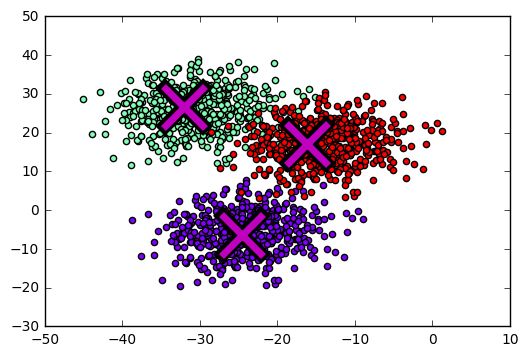

In [36]:
import tensorflow as tf
import numpy as np
import time

n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor = 70
min_distance = 10

np.random.seed(seed)

centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)
initial_centroids = choose_random_centroids(samples, n_clusters, seed)

model = tf.initialize_all_variables()
with tf.Session() as session:
    sample_values = session.run(samples)
    last_values = None
    iterations = 0
    while True:
        iterations += 1
        nearest_indices = assign_to_nearest(samples, initial_centroids)
        updated_centroids = update_centroids(samples, nearest_indices, n_clusters)
        updated_centroid_values = session.run(updated_centroids)
        if last_values is not None and np.linalg.norm(updated_centroid_values - last_values) < min_distance:
            break
        last_values = updated_centroid_values

    print(iterations)
    
plot_clusters(sample_values, updated_centroid_values, n_samples_per_cluster)

In [41]:
import tensorflow as tf
import numpy as np

x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
a = tf.Variable(1.0, name="a")
b = tf.Variable(2.0, name="b")

def model(x, a, b):
    return tf.mul(x, a) + b

y_model = model(x, a, b)
error = tf.square(y_model - y)
train_op = tf.train.GradientDescentOptimizer(0.01).minimize(error)

model = tf.initialize_all_variables()
with tf.Session() as session:
    session.run(model)
    for i in range(1000):
        x_value = np.random.rand(50)
        y_value = x_value * 2 + 6
        session.run(train_op, feed_dict={x: x_value, y: y_value})
        
    print(session.run([a, b]))

[2.0, 6.0]
